In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import copy
import tqdm
import matplotlib.pyplot as plt

In [2]:
# Check available CUDA devices and memory
if torch.cuda.is_available():
    num_devices = torch.cuda.device_count()
    for i in range(num_devices):
        device = torch.cuda.device(i)
        total_mem = torch.cuda.get_device_properties(i).total_memory / 1024**3  # Convert to GB
        allocated_mem = torch.cuda.memory_allocated(i) / 1024**3  # Convert to GB
        free_mem = total_mem - allocated_mem
        
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"Total Memory: {total_mem:.1f}GB")
        print(f"Allocated Memory: {allocated_mem:.1f}GB")
        print(f"Free Memory: {free_mem:.1f}GB")
        
        if free_mem < 8:
            print(f"Warning: GPU {i} has less than 8GB of free VRAM!")
        else:
            print(f"Using GPU {i} with {free_mem:.1f}GB free VRAM")
            break 
    device = torch.device(f"cuda:{i}")
else:
    print("Warning: No CUDA devices available - running on CPU only")
    device = torch.device("cpu")

GPU 0: NVIDIA GeForce RTX 4070 Ti
Total Memory: 12.0GB
Allocated Memory: 0.0GB
Free Memory: 12.0GB
Using GPU 0 with 12.0GB free VRAM


In [3]:
# Define regression dataset
class SolarPV(Dataset):
    # Initialise dataset
    def __init__(self, df, seq_length=64):
        self.features = df.drop(columns=['datetime', 'GG']).values.astype('float32')
        self.targets = df['GG'].values.astype('float32')
        self.seq_length = seq_length

    # Return length of dataset
    def __len__(self):
        return len(self.features) - self.seq_length

    # Load and return item from dataset
    def __getitem__(self, idx):
        x = self.features[idx:idx + self.seq_length]
        y = self.targets[idx + self.seq_length]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [4]:
# Define LSTM regression model class
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, output_size=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    # Forward pass through the model
    # x: input tensor of shape (batch_size, seq_length, input_size)
    # Returns output tensor of shape (batch_size, output_size)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Get the last time step
        return out.squeeze(1)

In [5]:
# Train local model
def train_local(model, dataloader, epochs, lr, device):
    model.to(device)
    model.train()
    # Define loss function and optimiser
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        #model.train()
        total_loss = 0.0
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()

            # Forward pass
            pred = model(x_batch)

            # Compute loss
            loss = criterion(pred, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        # Average loss for the epoch
        avg_loss = total_loss / len(dataloader)
        
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}")
    return model.state_dict()

In [6]:
# Aggregate local model parameters
def aggregate_params(local_params):
    # Assign first local model parameters
    avg_params = copy.deepcopy(local_params[0])
    # Iterate through each key in parameters
    for key in avg_params.keys():
        for i in range(1, len(local_params)):
            avg_params[key] += local_params[i][key]

        # Compute average
        avg_params[key] = avg_params[key] / len(local_params)

    return avg_params

In [7]:
def fl_train(global_model, dataloaders, rounds, local_epochs, lr, device):
    # FL training loop
    for round in range(rounds):
        print(f"--- Federated Learning Round {round + 1}/{rounds} ---")
        local_params = []
        
        # Train local models and collect parameters
        for i, dataloader in enumerate(dataloaders):
            print(f"Training Community {i + 1} local model")
            # Distribute copy of global model to each community
            local_model = copy.deepcopy(global_model)
            # Train local model on community data
            local_param = train_local(local_model, dataloader, local_epochs, lr, device)
            # Save and return local model parameters
            local_params.append(local_param)
        
        # Aggregate parameters from all local models
        agg_params = aggregate_params(local_params)
        
        # Update global model with aggregated parameters
        global_model.load_state_dict(agg_params)

In [8]:
# FL with final round of community training
def fl_train_v2(global_model, dataloaders, rounds, local_epochs, lr, device):
    # FL training loop
    for round in range(rounds):
        print(f"--- Federated Learning Round {round + 1}/{rounds} ---")
        local_params = []
        
        # Train local models and collect parameters
        for i, dataloader in enumerate(dataloaders):
            print(f"Training Community {i + 1} local model")
            # Distribute copy of global model to each community
            local_model = copy.deepcopy(global_model)
            # Train local model on community data
            local_param = train_local(local_model, dataloader, local_epochs, lr, device)
            # Save and return local model parameters
            local_params.append(local_param)
        
        # Aggregate parameters from all local models
        agg_params = aggregate_params(local_params)
        
        # Update global model with aggregated parameters
        global_model.load_state_dict(agg_params)
    
    # Final round of community training
    print ("--- Final Community Training Round ---")
    final_models = []
    # Train local models and collect parameters
    for i, dataloader in enumerate(dataloaders):
        print(f"Training Community {i + 1} local model")
        # Distribute copy of global model to each community
        local_model = copy.deepcopy(global_model)
        # Train local model on community data
        local_param = train_local(local_model, dataloader, local_epochs, lr, device)
        # Save and return local models
        final_models.append(local_model)
    
    return final_models

In [9]:
# Evaluate model
def evaluate(model, dataloader, device):
    model.to(device)
    model.eval()
    preds = []
    targets = []

    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            pred = model(x_batch)

            preds.extend(pred.cpu().numpy())
            targets.extend(y_batch.cpu().numpy())
            

    mae = mean_absolute_error(targets, preds)
    mse = mean_squared_error(targets, preds)
    rmse = np.sqrt(mse)
    #mape = np.mean(np.abs((np.array(targets) - np.array(preds)) / np.array(targets))) * 100
    r2 = r2_score(targets, preds)
    print(f"Evaluation - MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, R2 Score: {r2:.4f}")
    return preds, targets

In [10]:
def fl_test(model, dataloaders, scaler_output_list, device):
    for i, test_loader in enumerate(dataloaders):
        print(f"Evaluating global model on Community {i + 1} test data")
        #print(f"Evaluating Community {i + 1} model")
        preds, targets = evaluate(model, test_loader, device)
        
        # Inverse transform predictions and targets
        scaler_output = scaler_output_list[i]
        preds_unscaled = scaler_output.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()
        targets_unscaled = scaler_output.inverse_transform(np.array(targets).reshape(-1, 1)).flatten()
        
        # Print evaluation metrics
        mae = mean_absolute_error(targets_unscaled, preds_unscaled)
        mse = mean_squared_error(targets_unscaled, preds_unscaled)
        rmse = np.sqrt(mse)
        r2 = r2_score(targets_unscaled, preds_unscaled)
        print(f"Community {i + 1} Evaluation:")
        print(f"MAE  (Mean Absolute Error):      {mae:.4f}")
        print(f"MSE  (Mean Squared Error):       {mse:.4f}")
        print(f"RMSE (Root Mean Squared Error):  {rmse:.4f}")
        #print(f"MAPE (Mean Absolute % Error):    {mape:.2f}%")
        print(f"R²   (Coefficient of Determination): {r2:.4f}")

        plt.figure(figsize=(12, 5))
        plt.plot(targets_unscaled[8000:8400], label='Actual', linestyle='-', marker='o', alpha=0.7)
        plt.plot(preds_unscaled[8000:8400], label='Predicted', color="red", linestyle='--', marker='x', alpha=0.7)
        plt.title(f"Community {i + 1} Predicted vs Actual Solar Generation")
        plt.xlabel("Half-hourly Sample")
        plt.ylabel("Solar Generation (kW)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [11]:
def fl_test_v2(final_models, dataloaders, scaler_output_list, device):
    for i, test_loader in enumerate(dataloaders):
        print(f"Evaluating global model on Community {i + 1} test data")
        #print(f"Evaluating Community {i + 1} model")
        preds, targets = evaluate(final_models[i], test_loader, device)
        
        # Inverse transform predictions and targets
        scaler_output = scaler_output_list[i]
        preds_unscaled = scaler_output.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()
        targets_unscaled = scaler_output.inverse_transform(np.array(targets).reshape(-1, 1)).flatten()
        
        # Print evaluation metrics
        mae = mean_absolute_error(targets_unscaled, preds_unscaled)
        mse = mean_squared_error(targets_unscaled, preds_unscaled)
        rmse = np.sqrt(mse)
        r2 = r2_score(targets_unscaled, preds_unscaled)
        print(f"Community {i + 1} Evaluation:")
        print(f"MAE  (Mean Absolute Error):      {mae:.4f}")
        print(f"MSE  (Mean Squared Error):       {mse:.4f}")
        print(f"RMSE (Root Mean Squared Error):  {rmse:.4f}")
        #print(f"MAPE (Mean Absolute % Error):    {mape:.2f}%")
        print(f"R²   (Coefficient of Determination): {r2:.4f}")

        plt.figure(figsize=(12, 5))
        plt.plot(targets_unscaled[8000:8400], label='Actual', linestyle='-', marker='o', alpha=0.7)
        plt.plot(preds_unscaled[8000:8400], label='Predicted', color="red", linestyle='--', marker='x', alpha=0.7)
        plt.title(f"Community {i + 1} Predicted vs Actual Solar Generation")
        plt.xlabel("Half-hourly Sample")
        plt.ylabel("Solar Generation (kW)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [12]:
def create_dataloaders(df, batch_size=16):
    df_train = df[df["datetime"] < "2012-07-01"]
    df_test = df[df["datetime"] >= "2012-07-01"]
    # Create a copy of the DataFrames to avoid modifying the original data
    df_train = df_train.copy()
    df_test = df_test.copy()

    numerical_columns = ["NL", "NL_t-24", "NL_t-24*7", "NL_t-24*30"]
    target_column = ["GG"]

    # Apply data normalization [0, 1] for numerical columns and target column
    scaler_input = MinMaxScaler()
    scaler_output = MinMaxScaler()
    df_train[numerical_columns] = scaler_input.fit_transform(df_train[numerical_columns])
    df_test[numerical_columns] = scaler_input.transform(df_test[numerical_columns])

    df_train[target_column] = scaler_output.fit_transform(df_train[target_column])
    df_test[target_column] = scaler_output.transform(df_test[target_column])

    # Create DataLoader for training data
    train_dataset = SolarPV(df_train)
    train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)

    # Create DataLoader for test data
    test_dataset = SolarPV(df_test)
    test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False)
    
    return train_dataloader, test_dataloader, scaler_output

In [13]:
train_dataloader_list = []
test_dataloader_list = []
scaler_output_list = []

for i in range(1, 5):
    # Load dataset for each community
    df = pd.read_csv(f"./flmodel_data/community_{i}.csv")
    train_dataloader, test_dataloader, scaler_output = create_dataloaders(df)
    
    train_dataloader_list.append(train_dataloader)
    test_dataloader_list.append(test_dataloader)
    scaler_output_list.append(scaler_output)

In [14]:
for i, train_loader in enumerate(train_dataloader_list):
    X_sample, y_sample = next(iter(train_loader))  # Get first batch
    print(f"Community {i+1}: Feature Shape {X_sample.shape}, Target Shape {y_sample.shape}")

Community 1: Feature Shape torch.Size([16, 64, 21]), Target Shape torch.Size([16])
Community 2: Feature Shape torch.Size([16, 64, 21]), Target Shape torch.Size([16])
Community 3: Feature Shape torch.Size([16, 64, 21]), Target Shape torch.Size([16])
Community 4: Feature Shape torch.Size([16, 64, 21]), Target Shape torch.Size([16])


In [15]:
for i, scaler in enumerate(scaler_output_list):
    print(f"Community {i+1}: Scaler Min {scaler.data_min_}, Scaler Max {scaler.data_max_}")

Community 1: Scaler Min [0.], Scaler Max [54.398]
Community 2: Scaler Min [0.], Scaler Max [52.468]
Community 3: Scaler Min [0.], Scaler Max [52.117]
Community 4: Scaler Min [0.], Scaler Max [49.271]


In [16]:
for i, train_loader in enumerate(train_dataloader_list):
    train_size = len(train_loader.dataset)
    test_size = len(test_dataloader_list[i].dataset)
    print(f"Community {i+1}: Train Size {train_size}, Test Size {test_size}")

Community 1: Train Size 23328, Test Size 11616
Community 2: Train Size 23328, Test Size 11616
Community 3: Train Size 23328, Test Size 11616
Community 4: Train Size 23328, Test Size 11616


In [17]:
# Define global model
global_model = LSTMModel(input_size=train_dataloader_list[0].dataset.features.shape[1]).to(device)
# Train federated learning model
fl_train(global_model, train_dataloader_list, rounds=4, local_epochs=5, lr=0.001, device=device)


--- Federated Learning Round 1/4 ---
Training Community 1 local model
Epoch [1/5], Loss: 0.0152
Epoch [2/5], Loss: 0.0050
Epoch [3/5], Loss: 0.0040
Epoch [4/5], Loss: 0.0035
Epoch [5/5], Loss: 0.0032
Training Community 2 local model
Epoch [1/5], Loss: 0.0163
Epoch [2/5], Loss: 0.0059
Epoch [3/5], Loss: 0.0046
Epoch [4/5], Loss: 0.0042
Epoch [5/5], Loss: 0.0040
Training Community 3 local model
Epoch [1/5], Loss: 0.0158
Epoch [2/5], Loss: 0.0054
Epoch [3/5], Loss: 0.0044
Epoch [4/5], Loss: 0.0039
Epoch [5/5], Loss: 0.0036
Training Community 4 local model
Epoch [1/5], Loss: 0.0159
Epoch [2/5], Loss: 0.0053
Epoch [3/5], Loss: 0.0043
Epoch [4/5], Loss: 0.0038
Epoch [5/5], Loss: 0.0035
--- Federated Learning Round 2/4 ---
Training Community 1 local model
Epoch [1/5], Loss: 0.0034
Epoch [2/5], Loss: 0.0030
Epoch [3/5], Loss: 0.0029
Epoch [4/5], Loss: 0.0028
Epoch [5/5], Loss: 0.0027
Training Community 2 local model
Epoch [1/5], Loss: 0.0041
Epoch [2/5], Loss: 0.0037
Epoch [3/5], Loss: 0.0035


Evaluating global model on Community 1 test data
Evaluation - MAE: 0.0355, MSE: 0.0036, RMSE: 0.0603, R2 Score: 0.9542
Community 1 Evaluation:
MAE  (Mean Absolute Error):      1.9308
MSE  (Mean Squared Error):       10.7639
RMSE (Root Mean Squared Error):  3.2808
R²   (Coefficient of Determination): 0.9542


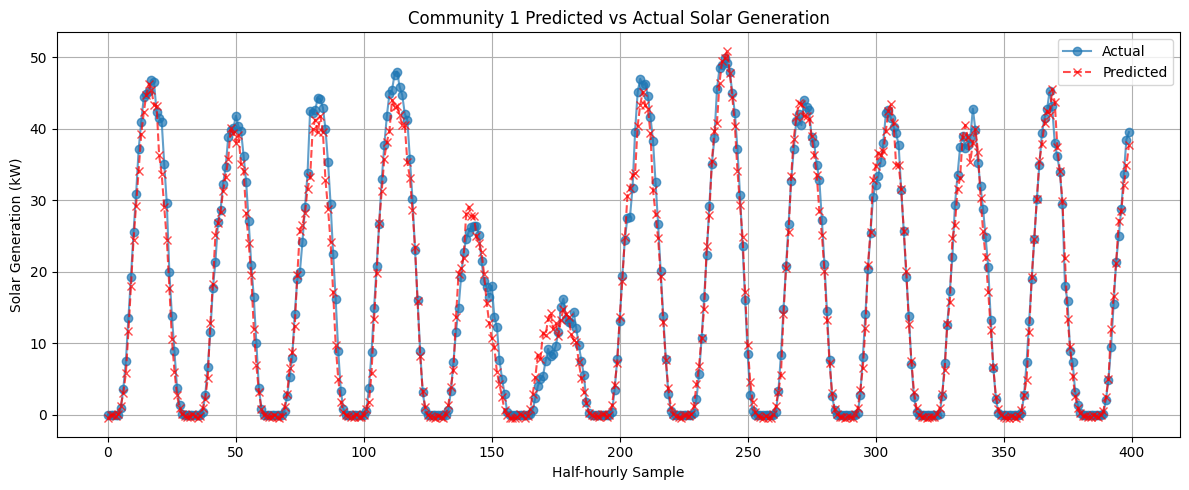

Evaluating global model on Community 2 test data
Evaluation - MAE: 0.0393, MSE: 0.0043, RMSE: 0.0653, R2 Score: 0.9447
Community 2 Evaluation:
MAE  (Mean Absolute Error):      2.0618
MSE  (Mean Squared Error):       11.7558
RMSE (Root Mean Squared Error):  3.4287
R²   (Coefficient of Determination): 0.9447


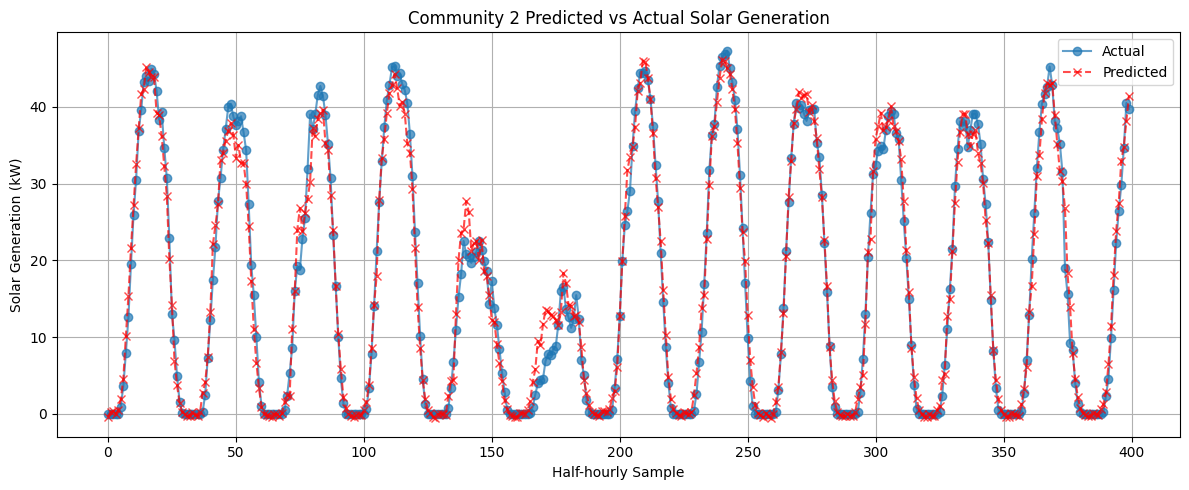

Evaluating global model on Community 3 test data
Evaluation - MAE: 0.0379, MSE: 0.0037, RMSE: 0.0609, R2 Score: 0.9539
Community 3 Evaluation:
MAE  (Mean Absolute Error):      1.9743
MSE  (Mean Squared Error):       10.0719
RMSE (Root Mean Squared Error):  3.1736
R²   (Coefficient of Determination): 0.9539


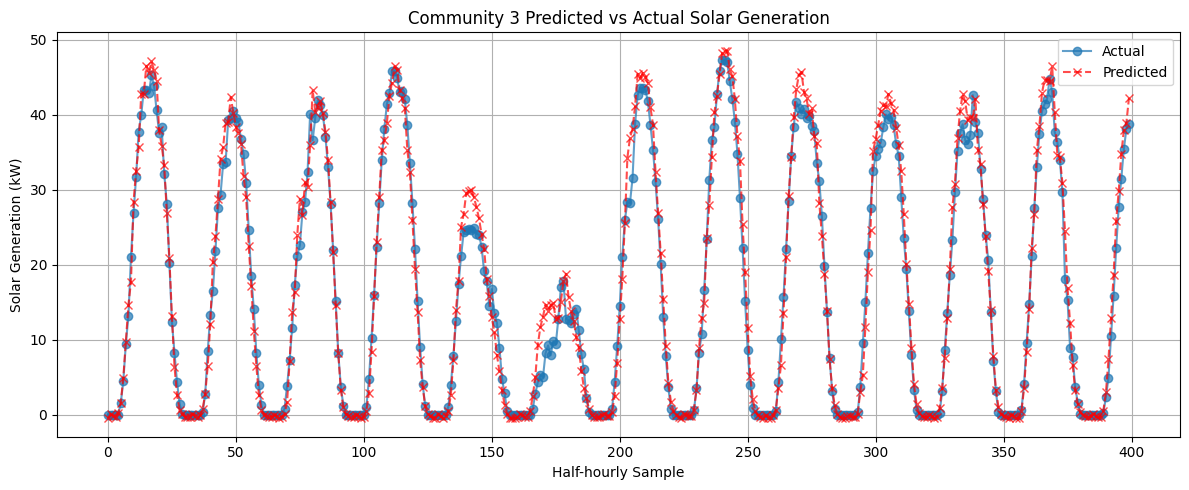

Evaluating global model on Community 4 test data
Evaluation - MAE: 0.0380, MSE: 0.0040, RMSE: 0.0630, R2 Score: 0.9532
Community 4 Evaluation:
MAE  (Mean Absolute Error):      1.8702
MSE  (Mean Squared Error):       9.6314
RMSE (Root Mean Squared Error):  3.1035
R²   (Coefficient of Determination): 0.9532


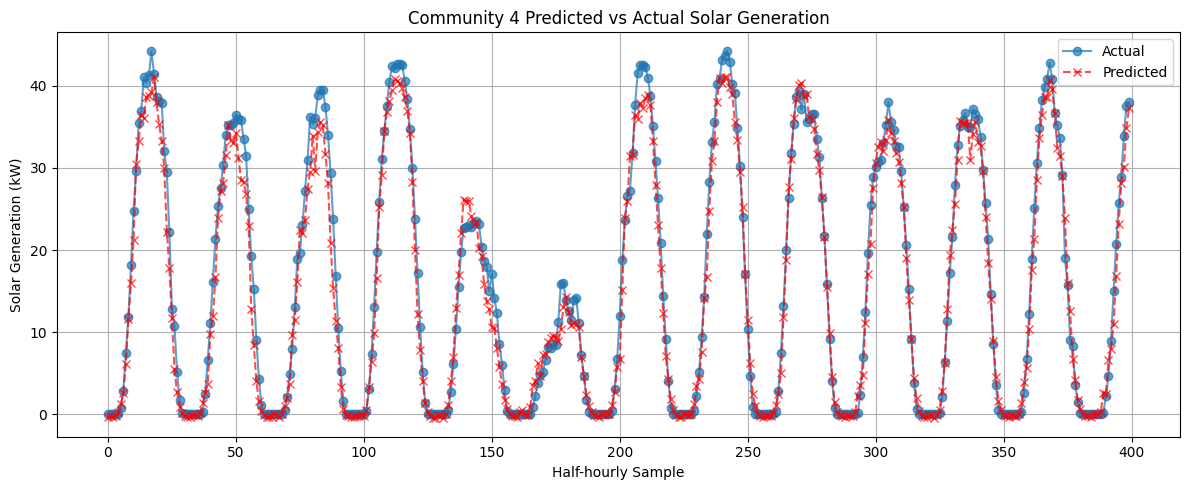

In [18]:
# Evaluate global model on each community's test data
fl_test(global_model, test_dataloader_list, scaler_output_list, device)

In [19]:
# Define global model
global_model_v2 = LSTMModel(input_size=train_dataloader_list[0].dataset.features.shape[1]).to(device)
# Train federated learning model
final_models = fl_train_v2(global_model_v2, train_dataloader_list, rounds=3, local_epochs=5, lr=0.001, device=device)


--- Federated Learning Round 1/3 ---
Training Community 1 local model
Epoch [1/5], Loss: 0.0146
Epoch [2/5], Loss: 0.0050
Epoch [3/5], Loss: 0.0041
Epoch [4/5], Loss: 0.0036
Epoch [5/5], Loss: 0.0034
Training Community 2 local model
Epoch [1/5], Loss: 0.0159
Epoch [2/5], Loss: 0.0060
Epoch [3/5], Loss: 0.0048
Epoch [4/5], Loss: 0.0042
Epoch [5/5], Loss: 0.0039
Training Community 3 local model
Epoch [1/5], Loss: 0.0153
Epoch [2/5], Loss: 0.0053
Epoch [3/5], Loss: 0.0043
Epoch [4/5], Loss: 0.0040
Epoch [5/5], Loss: 0.0037
Training Community 4 local model
Epoch [1/5], Loss: 0.0152
Epoch [2/5], Loss: 0.0054
Epoch [3/5], Loss: 0.0043
Epoch [4/5], Loss: 0.0037
Epoch [5/5], Loss: 0.0035
--- Federated Learning Round 2/3 ---
Training Community 1 local model
Epoch [1/5], Loss: 0.0033
Epoch [2/5], Loss: 0.0031
Epoch [3/5], Loss: 0.0030
Epoch [4/5], Loss: 0.0029
Epoch [5/5], Loss: 0.0029
Training Community 2 local model
Epoch [1/5], Loss: 0.0040
Epoch [2/5], Loss: 0.0039
Epoch [3/5], Loss: 0.0035


Evaluating global model on Community 1 test data
Evaluation - MAE: 0.0395, MSE: 0.0045, RMSE: 0.0674, R2 Score: 0.9429
Community 1 Evaluation:
MAE  (Mean Absolute Error):      2.1472
MSE  (Mean Squared Error):       13.4350
RMSE (Root Mean Squared Error):  3.6654
R²   (Coefficient of Determination): 0.9429


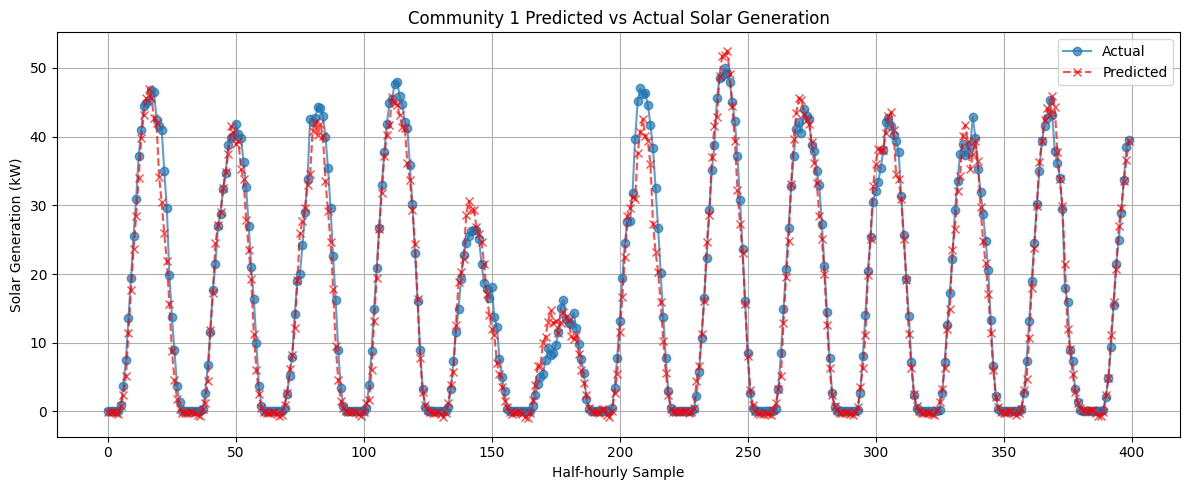

Evaluating global model on Community 2 test data
Evaluation - MAE: 0.0410, MSE: 0.0045, RMSE: 0.0669, R2 Score: 0.9420
Community 2 Evaluation:
MAE  (Mean Absolute Error):      2.1538
MSE  (Mean Squared Error):       12.3324
RMSE (Root Mean Squared Error):  3.5117
R²   (Coefficient of Determination): 0.9420


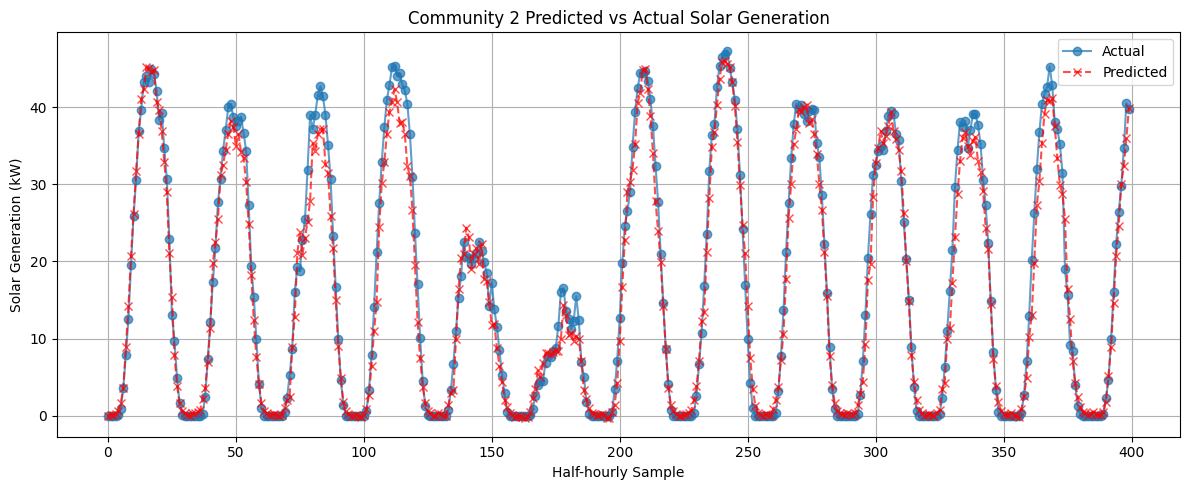

Evaluating global model on Community 3 test data
Evaluation - MAE: 0.0373, MSE: 0.0036, RMSE: 0.0597, R2 Score: 0.9556
Community 3 Evaluation:
MAE  (Mean Absolute Error):      1.9427
MSE  (Mean Squared Error):       9.6929
RMSE (Root Mean Squared Error):  3.1133
R²   (Coefficient of Determination): 0.9556


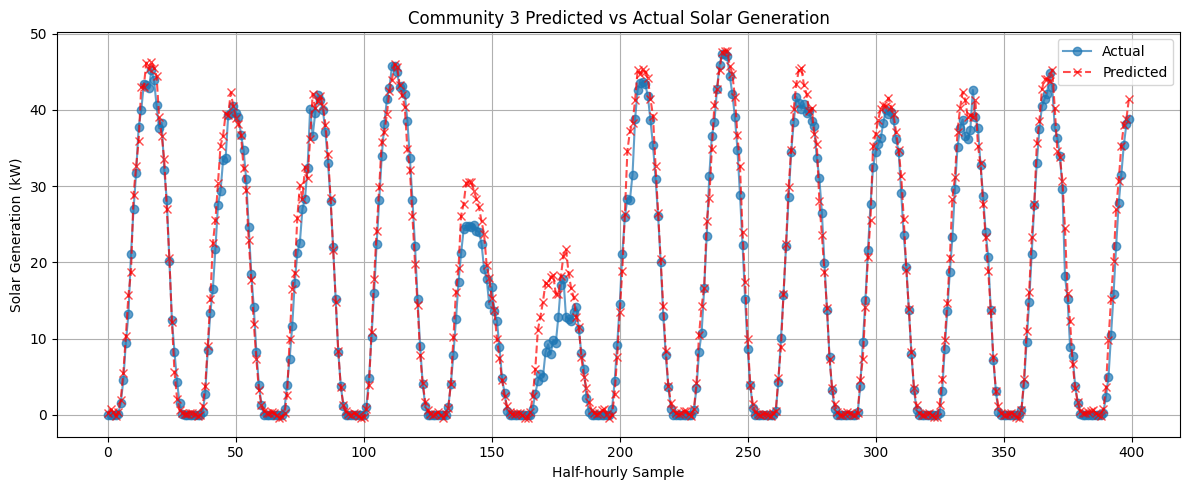

Evaluating global model on Community 4 test data
Evaluation - MAE: 0.0399, MSE: 0.0042, RMSE: 0.0647, R2 Score: 0.9506
Community 4 Evaluation:
MAE  (Mean Absolute Error):      1.9653
MSE  (Mean Squared Error):       10.1564
RMSE (Root Mean Squared Error):  3.1869
R²   (Coefficient of Determination): 0.9506


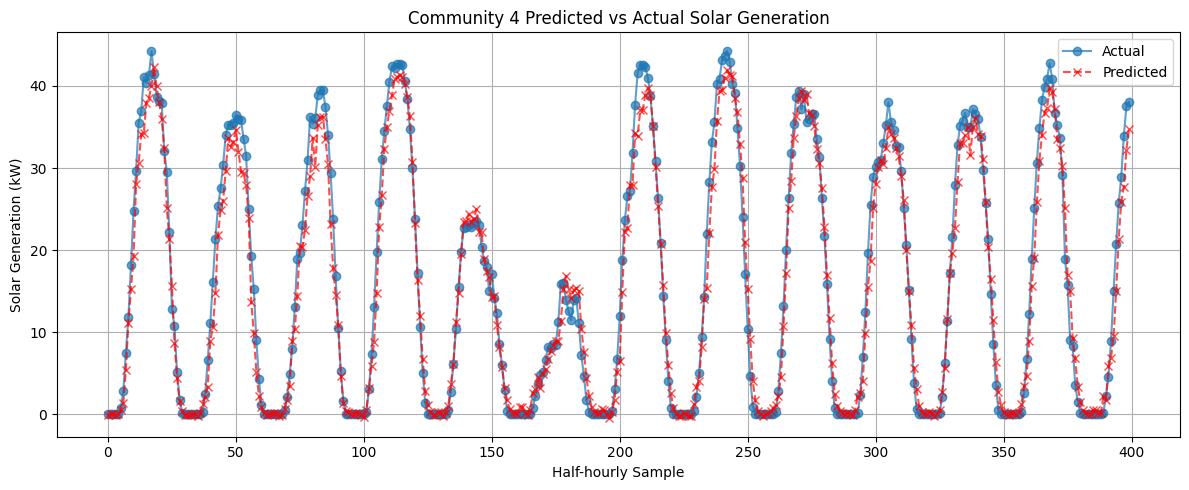

In [20]:
fl_test_v2(final_models, test_dataloader_list, scaler_output_list, device)